## Weighted Least Squares (WLS) regression
1. Load data and drop colinear features based on feature engineering + define same timesplits
2. define differene types of KERNELS to be used or tried + validate bandwidth
3. Test how many features to use
4. Compare and state differences

### Section 1: Load and Prepare Data & Rolling Time-Series Splits (as in the feature- engineering file)

In [1]:
# --- STEP 1: Load and prepare data for Weighted & Decision-Focused Learning experiments ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# === Read the cleaned final training dataset ===
train_df = pd.read_csv("data/final_data_train.csv", parse_dates=["ts"])

# Ensure chronological order
train_df = train_df.sort_values("ts").reset_index(drop=True)

# === Selected features (based on correlation and temporal encoding) ===
selected_features = [
    "power",                              # target
    "mean_wind_speed_Nex",
    "mean_wind_speed_Hammer_ Odde_Fyr",
    "mean_temp_Hammer_Odde_Fyr",
    "DK2_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "dayofweek"
]

# Filter relevant columns
data = train_df[selected_features].copy()

# --- Split into predictors and target ---
target_col = "power"
X = data.drop(columns=[target_col]).values
y = data[target_col].values
feature_names = data.drop(columns=[target_col]).columns.tolist()

# --- Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Scaled feature matrix shape: {X_scaled.shape}")
print(f"Features used: {feature_names}")

✅ Scaled feature matrix shape: (22422, 12)
Features used: ['mean_wind_speed_Nex', 'mean_wind_speed_Hammer_ Odde_Fyr', 'mean_temp_Hammer_Odde_Fyr', 'DK2_DKK', 'ImbalancePriceDKK', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofweek']


Lets also load the test data for the generalization error

In [2]:
test_df = pd.read_csv("data/final_data_test.csv", parse_dates=["ts"])
test_df = test_df.sort_values("ts").reset_index(drop=True)

test_data = test_df[selected_features].copy()  # same subset of columns
X_test = scaler.transform(test_data.drop(columns=["power"]).values)
y_test = test_data["power"].values


Lets build the splits

In [3]:
# --- STEP 2: Create time-based cross-validation splits (reused) ---
def build_time_splits(ts, window="6M", horizon="1M", step=None, verbose=True):
    """
    Rolling-origin time series splits (sliding window).
    Ensures validation covers the full horizon.
    """
    import pandas as pd
    ts = pd.to_datetime(pd.Series(ts)).sort_values().reset_index(drop=True)

    if step is None:
        step = horizon

    splits = []
    split_id = 1
    start_time = ts.min()

    while True:
        train_end = start_time + pd.tseries.frequencies.to_offset(window)
        val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)

        # stop if val_end goes beyond dataset max
        if val_end > ts.max():
            break

        train_idx = ts[(ts >= start_time) & (ts < train_end)].index.values
        val_idx   = ts[(ts >= train_end) & (ts < val_end)].index.values

        if len(val_idx) == 0 or len(train_idx) == 0:
            break

        splits.append((train_idx, val_idx))

        if verbose:
            print(f"Split {split_id}:")
            print(f"  Train: {ts.iloc[train_idx[0]]} → {ts.iloc[train_idx[-1]]}")
            print(f"  Valid: {ts.iloc[val_idx[0]]} → {ts.iloc[val_idx[-1]]}")
            print(f"End {split_id}:" + "-"*40)

        start_time = start_time + pd.tseries.frequencies.to_offset(step)
        split_id += 1

    return splits
# Example usage
ts = train_df["ts"].values
time_splits = build_time_splits(ts, window="2M", horizon="1M", step="1M", verbose=True)

print(f"Created {len(time_splits)} rolling splits.")

Split 1:
  Train: 2021-01-01 00:00:00 → 2021-02-26 17:00:00
  Valid: 2021-03-01 12:00:00 → 2021-03-30 23:00:00
End 1:----------------------------------------
Split 2:
  Train: 2021-01-31 00:00:00 → 2021-03-30 23:00:00
  Valid: 2021-03-31 00:00:00 → 2021-04-29 23:00:00
End 2:----------------------------------------
Split 3:
  Train: 2021-03-01 12:00:00 → 2021-04-29 23:00:00
  Valid: 2021-04-30 00:00:00 → 2021-05-30 23:00:00
End 3:----------------------------------------
Split 4:
  Train: 2021-03-31 00:00:00 → 2021-05-30 23:00:00
  Valid: 2021-05-31 00:00:00 → 2021-06-29 23:00:00
End 4:----------------------------------------
Split 5:
  Train: 2021-04-30 00:00:00 → 2021-06-29 23:00:00
  Valid: 2021-06-30 00:00:00 → 2021-07-30 23:00:00
End 5:----------------------------------------
Split 6:
  Train: 2021-05-31 00:00:00 → 2021-07-30 23:00:00
  Valid: 2021-07-31 00:00:00 → 2021-08-30 23:00:00
End 6:----------------------------------------
Split 7:
  Train: 2021-06-30 00:00:00 → 2021-08-30 2

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31429/3399254213.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_end = start_time + pd.tseries.frequencies.to_offset(window)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31429/3399254213.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31429/3399254213.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  start_time = start_time + pd.tseries.frequencies.to_offset(step)


Here we define differene types of KERNELS to be used or tried

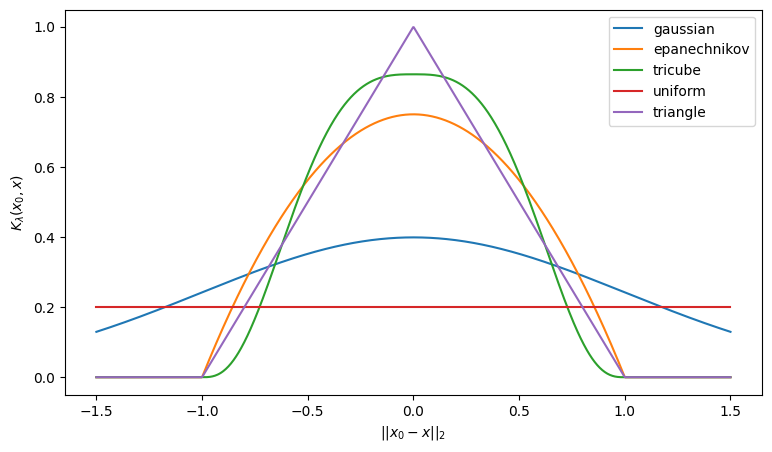

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi) # gaussian shape. It assigns weight close to 0 to points with distance 3 and weight close to 0.4 to points with distance 0

def epanechnikov(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2) # epanechnikov shape. It assigns weight 0 to points with distance 1 and weight 0.75 to points with distance 0
    return res

def tricube(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3 # tricube shape. It assigns weight 0 to points with distance 1 and weight 70/81 to points with distance 0
    return res

def uniform(t, p=0.2):
    return np.zeros_like(t) + p # uniform shape. It assigns weight p to all points

def triangle(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1]) # triangular shape. It assigns weight 0 to points with distance 1 and weight 1 to points with distance 0
    return res

fig, ax = plt.subplots(figsize=(9, 5))

xs = np.linspace(-1.5, 1.5, 1000)
for func in [gaussian, epanechnikov, tricube, uniform, triangle]:
    ax.plot(xs, func(xs), label=func.__name__)

ax.legend()
ax.set_ylabel("$K_{\lambda}(x_0, x)$")
ax.set_xlabel("$||x_0 - x||_2$")
#fig.tight_layout()
fig.canvas.draw()

Local weighted regression function. //implement the actual regression that fits a local linear model around each query point.

In [5]:
def weighted_ls_predict(X, y, X_query, bandwidth=0.3, kernel=None, lambda_reg=1e-6):
    """
    Predict y at query points using weighted least squares with Gaussian kernel.
    Added regularization to stabilize matrix inversion.
    """
    n_train, n_features = X.shape
    y_pred = np.zeros(X_query.shape[0])
    
    for i, x0 in enumerate(X_query):
        # Compute weights using kernel
        distances = np.linalg.norm(X - x0, axis=1)
        w = kernel(distances / bandwidth)
        
        # Skip if all weights are (almost) zero
        if np.all(w < 1e-10):
            y_pred[i] = np.nan
            continue
        
        W = np.diag(w)
        try:
            # Regularized weighted least squares
            XtWX = X.T @ W @ X + lambda_reg * np.eye(n_features)
            XtWy = X.T @ W @ y
            theta = np.linalg.solve(XtWX, XtWy)
            y_pred[i] = x0 @ theta
        except np.linalg.LinAlgError:
            y_pred[i] = np.nan
    
    return y_pred

## Key insight

Locally weighted regression does not scale well in high dimensions.
Once you have 9 standardized features, distances between points start to concentrate around a single value (the curse of dimensionality).
→ Every point is “far away” from every other point.
→ Kernels either give near-zero weights (underfit) or uniform weights (overfit).

That’s why this method shines mostly in low-dimensional cases (1–3 features).

## 🌐 Understanding Bandwidth (λ) in Locally Weighted Regression

The **bandwidth** controls *how local* each weighted least squares (WLS) fit is —  
that is, how far each training point “influences” a prediction at a query point.

---

### Mathematical definition

For a given query point $ x_0 $, locally weighted regression estimates:

$$
\hat{y}(x_0) = x_0^\top (X^\top W X)^{-1} X^\top W y
$$

where $ W $ is a diagonal matrix of weights based on the distance from $ x_0 $:

$$
W_{ii} = K\!\left(\frac{\|x_i - x_0\|}{\lambda}\right)
$$

Here:
- $ K(\cdot) $ is the kernel function (e.g., Gaussian, Epanechnikov, Tricube)
- $ \lambda $ is the **bandwidth** (the scaling factor for distances)

---

### Intuitive meaning of λ

| **Bandwidth (λ)** | **Interpretation** | **Effect** |
|--------------------|-------------------|-------------|
| **Small λ** | Only *very close* neighbors get high weights; distant points have ~0 influence | Very *local fit* — high variance, low bias (overfitting) |
| **Large λ** | Many points have nonzero weights; distant points also matter | *Smoother fit* — low variance, high bias (underfitting) |

So λ acts as a **smoothing parameter**, controlling the **bias–variance tradeoff**.

---

### Effect on the kernel (Gaussian example)

For a Gaussian kernel:

$$
K(t) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} t^2}, \quad t = \frac{\|x - x_0\|}{\lambda}
$$

- Small λ → $ t $ is large for even small distances → $ K(t) \approx 0 $ except for a few close points → very local, noisy fit.  
- Large λ → $ t $ is small for most distances → $ K(t) \approx \text{constant} $ → becomes almost *global regression*.

---

### Computational effect

✅ Yes — **larger λ tends to make the algorithm slower**.

- For small λ: most weights ≈ 0 → only a few points affect each local regression (faster).  
- For large λ: many weights > 0 → almost all points influence each prediction (slower matrix operations).

Runtime roughly scales with **how many nonzero weights** exist for each local fit.

---

### Visual analogy

Think of λ as the **radius of a spotlight** around your query point:
- **Small λ** → tight spotlight → precise but noisy (local, high variance).  
- **Large λ** → wide soft light → smooth but blurry (global, high bias).

---

### Practical guidelines

- λ ≈ 0.3–0.6 → good for **standardized 1–3D data** (like wind speed & imbalance price).  
- λ ≈ 1.0+ → behaves more like **global OLS**.  
- λ is typically tuned by minimizing **validation RMSE** (as in your current workflow).


In [6]:
# --- Select only wind speed and imbalance price ---
X_2d = X_scaled[:, [
    feature_names.index("mean_wind_speed_Nex"),
    feature_names.index("ImbalancePriceDKK")
]]

print(f"X_2d shape: {X_2d.shape}")

X_2d shape: (22422, 2)


Number of query points: 400
Evaluating bandwidths for Weighted LS at query points:
Bandwidth 0.10 → Avg Validation RMSE = 0.3491
Bandwidth 0.12 → Avg Validation RMSE = 0.3453
Bandwidth 0.15 → Avg Validation RMSE = 0.3402
Bandwidth 0.17 → Avg Validation RMSE = 0.3369
Bandwidth 0.20 → Avg Validation RMSE = 0.3364
Bandwidth 0.22 → Avg Validation RMSE = 0.3380
Bandwidth 0.25 → Avg Validation RMSE = 0.3379
Bandwidth 0.27 → Avg Validation RMSE = 0.3378

✅ Optimal bandwidth (λ): 0.200


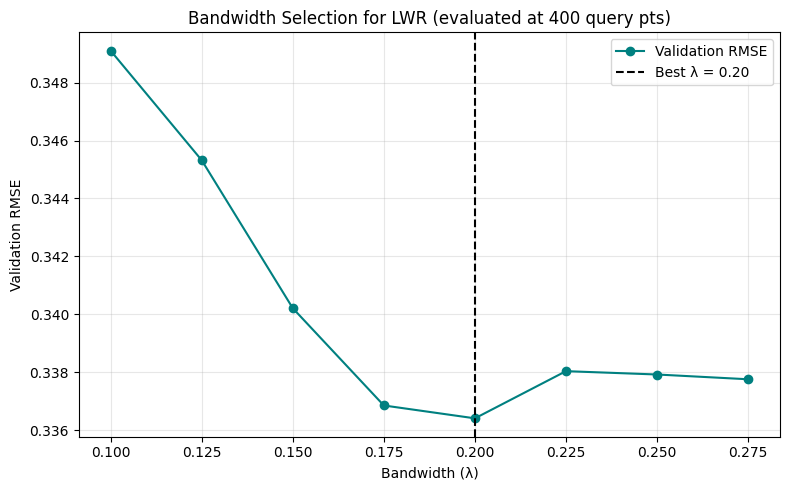

In [7]:
from sklearn.metrics import mean_squared_error
from scipy.spatial import cKDTree

# --- Define query (fitting) points ---
wind_idx = feature_names.index("mean_wind_speed_Nex")
price_idx = feature_names.index("ImbalancePriceDKK")

# control density of grid (you can increase n_wind/n_price for smoother surface)
n_wind, n_price = 20, 20
wind_grid = np.linspace(X_scaled[:, wind_idx].min(), X_scaled[:, wind_idx].max(), n_wind)
price_grid = np.linspace(X_scaled[:, price_idx].min(), X_scaled[:, price_idx].max(), n_price)
Wq, Pq = np.meshgrid(wind_grid, price_grid)
X_query = np.column_stack([Wq.ravel(), Pq.ravel()])

print(f"Number of query points: {len(X_query)}")

# --- Bandwidth tuning ---
bandwidths = np.arange(0.1, 0.3, 0.025)
val_rmse_means = []

print("Evaluating bandwidths for Weighted LS at query points:")
print("="*70)

for bw in bandwidths:
    rmse_fold = []
    
    for train_idx, val_idx in time_splits:
        X_train, y_train = X_2d[train_idx], y[train_idx]
        X_val, y_val     = X_2d[val_idx], y[val_idx]
        
        # Predict at fixed query points
        y_query_pred = weighted_ls_predict(X_train, y_train, X_query, bandwidth=bw, kernel=gaussian)
        
        # Match each validation point to nearest query point
        tree = cKDTree(X_query)
        _, nearest_idx = tree.query(X_val)
        y_val_pred = y_query_pred[nearest_idx]
        
        mask = ~np.isnan(y_val_pred)
        if np.any(mask):
            rmse = np.sqrt(mean_squared_error(y_val[mask], y_val_pred[mask]))
            rmse_fold.append(rmse)
    
    val_rmse_means.append(np.mean(rmse_fold) if rmse_fold else np.nan)
    print(f"Bandwidth {bw:.2f} → Avg Validation RMSE = {val_rmse_means[-1]:.4f}")

# --- Identify optimal λ ---
best_bw_idx = np.nanargmin(val_rmse_means)
best_bw = bandwidths[best_bw_idx]
print(f"\n✅ Optimal bandwidth (λ): {best_bw:.3f}")

# --- Plot validation curve ---
plt.figure(figsize=(8,5))
plt.plot(bandwidths, val_rmse_means, "o-", color="teal", label="Validation RMSE")
plt.axvline(best_bw, color="k", linestyle="--", label=f"Best λ = {best_bw:.2f}")
plt.xlabel("Bandwidth (λ)")
plt.ylabel("Validation RMSE")
plt.title(f"Bandwidth Selection for LWR (evaluated at {len(X_query)} query pts)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization
1. 2D Cross-section Plot
2. 3D Surface Plot (Wind Speed, Price → Power)

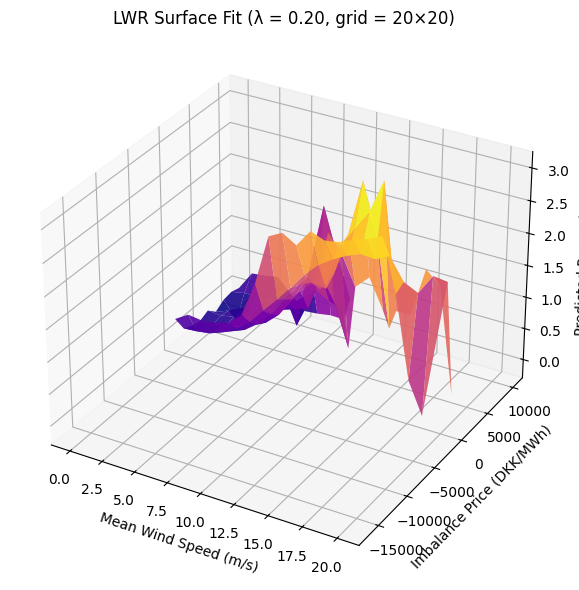

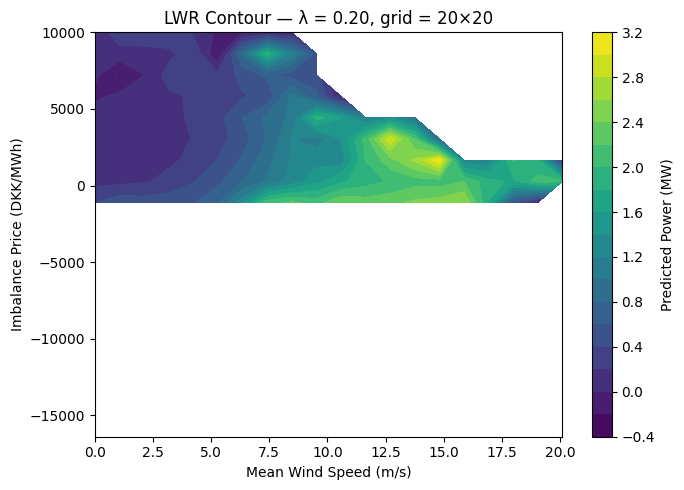

In [8]:
# **********************************"Runtime of approx 2.5–4 minutes"*****************************************************

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# --- Reuse your query grid (same as during validation) ---
n_wind, n_price = 20, 20  # keep same granularity as before
wind_idx = feature_names.index("mean_wind_speed_Nex")
price_idx = feature_names.index("ImbalancePriceDKK")

wind_grid = np.linspace(X_scaled[:, wind_idx].min(), X_scaled[:, wind_idx].max(), n_wind)
price_grid = np.linspace(X_scaled[:, price_idx].min(), X_scaled[:, price_idx].max(), n_price)
Wq, Pq = np.meshgrid(wind_grid, price_grid)
X_query = np.column_stack([Wq.ravel(), Pq.ravel()])

# --- Predict using trained LWR (best bandwidth found) ---
Y_pred = weighted_ls_predict(X_2d, y, X_query, bandwidth=best_bw, kernel=gaussian)
Y_pred = Y_pred.reshape(Wq.shape)

# --- Unscale to physical units for plotting ---
mean_wind = scaler.mean_[wind_idx]
std_wind = scaler.scale_[wind_idx]
mean_price = scaler.mean_[price_idx]
std_price = scaler.scale_[price_idx]

wind_unscaled = mean_wind + std_wind * Wq
price_unscaled = mean_price + std_price * Pq

# --- 3D surface plot ---
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(wind_unscaled, price_unscaled, Y_pred, cmap="plasma", alpha=0.9, edgecolor="none")

ax.set_xlabel("Mean Wind Speed (m/s)")
ax.set_ylabel("Imbalance Price (DKK/MWh)")
ax.set_zlabel("Predicted Power (MW)")
ax.set_title(f"LWR Surface Fit (λ = {best_bw:.2f}, grid = {n_wind}×{n_price})")
plt.tight_layout()
plt.show()

# --- 2D contour view (optional for report) ---
plt.figure(figsize=(7,5))
contour = plt.contourf(wind_unscaled, price_unscaled, Y_pred, levels=20, cmap="viridis")
plt.colorbar(contour, label="Predicted Power (MW)")
plt.xlabel("Mean Wind Speed (m/s)")
plt.ylabel("Imbalance Price (DKK/MWh)")
plt.title(f"LWR Contour — λ = {best_bw:.2f}, grid = {n_wind}×{n_price}")
plt.tight_layout()
plt.show()

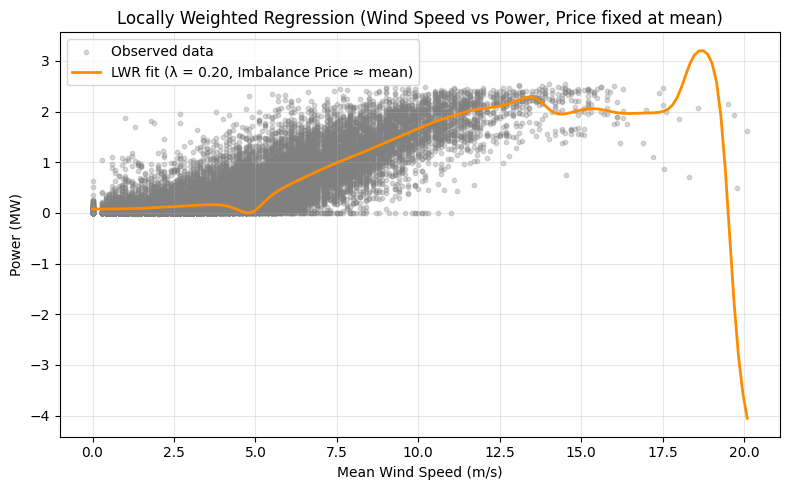

In [9]:
# **********************************"Runtime ≈ 1–2 minutes"*****************************************************

import matplotlib.pyplot as plt
import numpy as np

# --- Feature indices ---
wind_idx = feature_names.index("mean_wind_speed_Nex")
price_idx = feature_names.index("ImbalancePriceDKK")

# --- Fix imbalance price to its mean (in standardized space) ---
mean_price_std = X_scaled[:, price_idx].mean()

# --- Build a smooth grid of wind speeds (standardized space) ---
n_points = 150
wind_grid_std = np.linspace(X_scaled[:, wind_idx].min(), X_scaled[:, wind_idx].max(), n_points)

# Combine wind and fixed price to create query matrix
X_query = np.column_stack([wind_grid_std, np.full_like(wind_grid_std, mean_price_std)])

# --- Predict using locally weighted regression ---
y_pred_smooth = weighted_ls_predict(X_2d, y, X_query, bandwidth=best_bw, kernel=gaussian)

# --- Unscale standardized wind speed to physical units (m/s) ---
mean_wind = scaler.mean_[wind_idx]
std_wind = scaler.scale_[wind_idx]
wind_grid_mps = mean_wind + std_wind * wind_grid_std
wind_data_mps = mean_wind + std_wind * X_scaled[:, wind_idx]

# --- Plot ---
plt.figure(figsize=(8,5))
plt.scatter(wind_data_mps, y, color="gray", alpha=0.3, s=10, label="Observed data")
plt.plot(wind_grid_mps, y_pred_smooth, color="darkorange", linewidth=2,
         label=f"LWR fit (λ = {best_bw:.2f}, Imbalance Price ≈ mean)")
plt.xlabel("Mean Wind Speed (m/s)")
plt.ylabel("Power (MW)")
plt.title("Locally Weighted Regression (Wind Speed vs Power, Price fixed at mean)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Lets try 1D using only wind to see what this yields


X_1d shape: (22422, 1)
Evaluating bandwidths for Weighted LS (1D wind speed):
λ=0.010 → Avg Validation RMSE = 0.3408
λ=0.020 → Avg Validation RMSE = 0.3391
λ=0.030 → Avg Validation RMSE = 0.3346
λ=0.040 → Avg Validation RMSE = 0.3338
λ=0.050 → Avg Validation RMSE = 0.3349
λ=0.060 → Avg Validation RMSE = 0.3339

✅ Optimal bandwidth for 1D model: 0.040


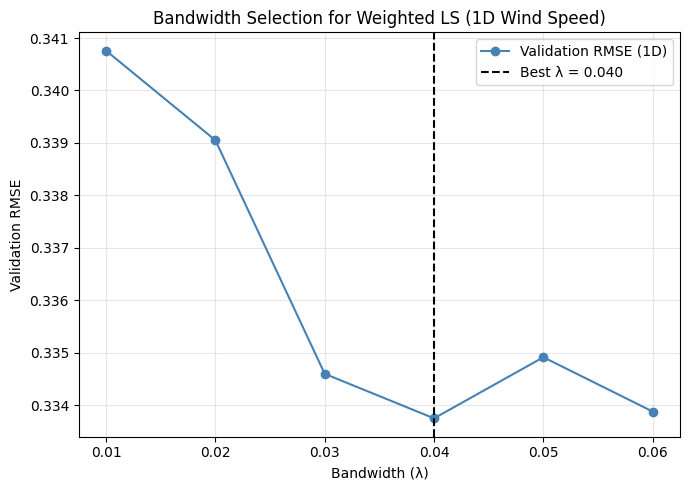

In [10]:
# **********************************"Runtime of approx 1.5 minutes"*****************************************************

from sklearn.metrics import mean_squared_error
from scipy.spatial import cKDTree

# --- Select only mean wind speed as input ---
X_1d = X_scaled[:, [feature_names.index("mean_wind_speed_Nex")]]
print(f"X_1d shape: {X_1d.shape}")

# --- Define query points (fixed across all λ) ---
n_query = 150
wind_query = np.linspace(X_1d.min(), X_1d.max(), n_query).reshape(-1, 1)
tree = cKDTree(wind_query)  # build tree once

# --- Bandwidths to test ---
bandwidths = np.arange(0.01, 0.061, 0.01)  # 0.01 → 0.06
val_rmse_means_1d = []

print("Evaluating bandwidths for Weighted LS (1D wind speed):")
print("=" * 60)

for bw in bandwidths:
    rmse_fold = []
    
    for train_idx, val_idx in time_splits:
        X_train, y_train = X_1d[train_idx], y[train_idx]
        X_val, y_val     = X_1d[val_idx], y[val_idx]
        
        # Predict at fixed query points
        y_query_pred = weighted_ls_predict(X_train, y_train, wind_query, bandwidth=bw, kernel=gaussian)
        
        # Find nearest query point for each validation sample
        _, nearest_idx = tree.query(X_val)
        y_val_pred = y_query_pred[nearest_idx]
        
        # Compute RMSE
        mask = ~np.isnan(y_val_pred)
        if np.any(mask):
            rmse = np.sqrt(mean_squared_error(y_val[mask], y_val_pred[mask]))
            rmse_fold.append(rmse)
    
    val_rmse_means_1d.append(np.mean(rmse_fold) if rmse_fold else np.nan)
    print(f"λ={bw:.3f} → Avg Validation RMSE = {val_rmse_means_1d[-1]:.4f}")

# --- Identify optimal bandwidth ---
best_bw_1d = bandwidths[np.nanargmin(val_rmse_means_1d)]
print(f"\n✅ Optimal bandwidth for 1D model: {best_bw_1d:.3f}")

# --- Plot validation curve ---
plt.figure(figsize=(7,5))
plt.plot(bandwidths, val_rmse_means_1d, "o-", color="steelblue", label="Validation RMSE (1D)")
plt.axvline(best_bw_1d, color="k", linestyle="--", label=f"Best λ = {best_bw_1d:.3f}")
plt.xlabel("Bandwidth (λ)")
plt.ylabel("Validation RMSE")
plt.title("Bandwidth Selection for Weighted LS (1D Wind Speed)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



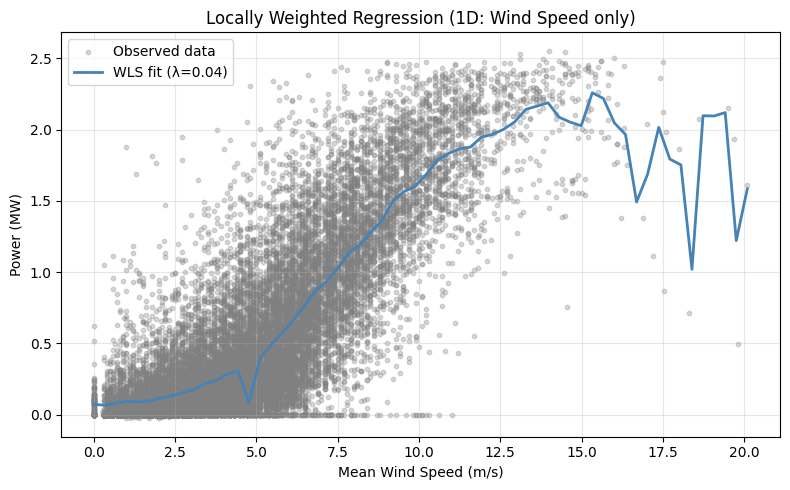

In [11]:
# Create smooth wind grid
wind_smooth_std = np.linspace(X_1d.min(), X_1d.max(), 60).reshape(-1, 1)

# Predict using best bandwidth
y_smooth_1d = weighted_ls_predict(X_1d, y, wind_smooth_std, bandwidth=best_bw_1d, kernel=gaussian)

# Unscale wind
mean_wind, std_wind = scaler.mean_[feature_names.index("mean_wind_speed_Nex")], \
                      scaler.scale_[feature_names.index("mean_wind_speed_Nex")]
wind_unscaled = mean_wind + std_wind * X_1d.ravel()
wind_smooth_unscaled = mean_wind + std_wind * wind_smooth_std.ravel()

# Plot fit
plt.figure(figsize=(8,5))
plt.scatter(wind_unscaled, y, color="gray", alpha=0.3, s=10, label="Observed data")
plt.plot(wind_smooth_unscaled, y_smooth_1d, color="steelblue", linewidth=2,
         label=f"WLS fit (λ={best_bw_1d:.2f})")
plt.xlabel("Mean Wind Speed (m/s)")
plt.ylabel("Power (MW)")
plt.title("Locally Weighted Regression (1D: Wind Speed only)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

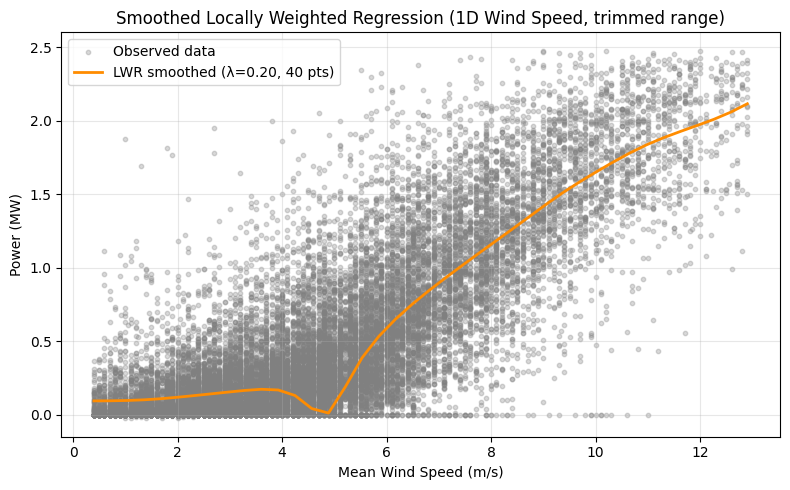

In [12]:
# Define adaptive plotting range (exclude extreme tails)
low, high = np.percentile(X_1d, [1, 99])
mask = (X_1d.ravel() >= low) & (X_1d.ravel() <= high)

# Smooth a bit more by increasing λ
best_bw_plot = 0.2  # slightly larger for stable visual
n_query = 40

wind_query = np.linspace(low, high, n_query).reshape(-1, 1)
y_smooth = weighted_ls_predict(X_1d[mask], y[mask], wind_query, bandwidth=best_bw_plot, kernel=gaussian)

# Unscale
mean_wind = scaler.mean_[feature_names.index("mean_wind_speed_Nex")]
std_wind = scaler.scale_[feature_names.index("mean_wind_speed_Nex")]
wind_query_unscaled = mean_wind + std_wind * wind_query.ravel()
wind_data_unscaled = mean_wind + std_wind * X_1d[mask].ravel()

# Plot smoother fit (trimmed range)
plt.figure(figsize=(8,5))
plt.scatter(wind_data_unscaled, y[mask], color="gray", alpha=0.3, s=10, label="Observed data")
plt.plot(wind_query_unscaled, y_smooth, color="darkorange", linewidth=2,
         label=f"LWR smoothed (λ={best_bw_plot:.2f}, {n_query} pts)")
plt.xlabel("Mean Wind Speed (m/s)")
plt.ylabel("Power (MW)")
plt.title("Smoothed Locally Weighted Regression (1D Wind Speed, trimmed range)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## lets test now 1d

In [13]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Select only wind speed feature (1D standardized) ---
wind_idx = feature_names.index("mean_wind_speed_Nex")

X_train_1d = X_scaled[:, [wind_idx]]
y_train_1d = y

X_test_1d = X_test[:, [wind_idx]]
y_test_true = y_test

# --- Step 2: Define grid of representative points (standardized space) ---
n_grid = 40  # denser grid since it's 1D
wind_std = X_train_1d.ravel()
wind_grid = np.linspace(wind_std.min(), wind_std.max(), n_grid).reshape(-1, 1)

# --- Step 3: Fit one local weighted regression for each grid point ---
theta_grid = np.zeros((n_grid, 1))  # only one coefficient (no intercept here)

for i, x0 in enumerate(wind_grid):
    distances = np.abs(wind_std - x0) / best_bw_1d
    weights = np.exp(-0.5 * distances**2) / np.sqrt(2 * np.pi)
    W = np.diag(weights)
    try:
        # Weighted Least Squares: θ = (XᵀWX)⁻¹ XᵀWy
        theta = np.linalg.inv(X_train_1d.T @ W @ X_train_1d) @ (X_train_1d.T @ W @ y_train_1d)
        theta_grid[i, 0] = theta
    except np.linalg.LinAlgError:
        theta_grid[i, 0] = np.nan

print(f"✅ Fitted {n_grid} local regressions (1D grid)")

# --- Step 4: Predict for each test sample using nearest local model ---
tree = cKDTree(wind_grid)
_, idx = tree.query(X_test_1d, k=1)
y_test_pred = (X_test_1d.ravel() * theta_grid[idx].ravel())

# Clip negative predictions
y_test_pred = np.maximum(y_test_pred, 0)

# --- Step 5: Evaluate performance ---
mask = ~np.isnan(y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_true[mask], y_test_pred[mask]))
mae_test = mean_absolute_error(y_test_true[mask], y_test_pred[mask])
r2_test = r2_score(y_test_true[mask], y_test_pred[mask])

print(f"\n📊 Generalization Performance (1D LWR on Wind Speed)")
print(f"   RMSE = {rmse_test:.4f}")
print(f"   MAE  = {mae_test:.4f}")
print(f"   R²   = {r2_test:.4f}")

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31429/2341233632.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_grid[i, 0] = theta


✅ Fitted 40 local regressions (1D grid)

📊 Generalization Performance (1D LWR on Wind Speed)
   RMSE = 0.4823
   MAE  = 0.3388
   R²   = -0.2496


## lets test now 2d

In [14]:
#!pip install numba

X_train_full = X_scaled[:, [
    feature_names.index("mean_wind_speed_Nex"),
    feature_names.index("ImbalancePriceDKK")
]]
y_train_full = y

# Prepare test features
X_test_2d = X_test[:, [
    feature_names.index("mean_wind_speed_Nex"),
    feature_names.index("ImbalancePriceDKK")
]]
y_test_true = y_test

In [15]:
# --- 11 minutes ---
import numpy as np
from scipy.spatial import cKDTree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Build grid of representative (standardized) feature points ---
n_grid = 20  # 20x20 = 400 local models
wind_idx = feature_names.index("mean_wind_speed_Nex")
price_idx = feature_names.index("ImbalancePriceDKK")

wind_std = X_scaled[:, wind_idx]
price_std = X_scaled[:, price_idx]

wind_grid = np.linspace(wind_std.min(), wind_std.max(), n_grid)
price_grid = np.linspace(price_std.min(), price_std.max(), n_grid)
W_grid, P_grid = np.meshgrid(wind_grid, price_grid)
grid_points = np.column_stack([W_grid.ravel(), P_grid.ravel()])

# --- Step 2: Fit one local weighted regression for each grid point ---
theta_grid = np.zeros((grid_points.shape[0], 2))  # 2 features
for i, x0 in enumerate(grid_points):
    distances = np.linalg.norm(X_2d - x0, axis=1) / best_bw
    weights = np.exp(-0.5 * distances**2) / np.sqrt(2*np.pi)
    W = np.diag(weights)
    try:
        theta = np.linalg.inv(X_2d.T @ W @ X_2d) @ (X_2d.T @ W @ y)
        theta_grid[i, :] = theta
    except np.linalg.LinAlgError:
        theta_grid[i, :] = np.nan
    if i % 100 == 0:
        print(f"Fitted {i}/{grid_points.shape[0]} local models...")

print(f"✅ Fitted {grid_points.shape[0]} local regressions (grid size {n_grid}×{n_grid})")

# --- Step 3: Assign each test point to nearest grid point ---
tree = cKDTree(grid_points)
dist, idx = tree.query(X_test_2d, k=1)

# Predict using nearest local model's θ
y_test_pred = np.einsum('ij,ij->i', X_test_2d, theta_grid[idx])

# --- Step 3.5: Clip negative values ---
y_test_pred = np.maximum(y_test_pred, 0)

# --- Step 4: Evaluate performance ---
mask = ~np.isnan(y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test[mask], y_test_pred[mask]))
mae_test = mean_absolute_error(y_test[mask], y_test_pred[mask])
r2_test = r2_score(y_test[mask], y_test_pred[mask])

print(f"\n📊 Generalization Performance (Grid-based LWR)")
print(f"   RMSE = {rmse_test:.4f}")
print(f"   MAE  = {mae_test:.4f}")
print(f"   R²   = {r2_test:.4f}")



Fitted 0/400 local models...


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31429/3844296861.py:27: RuntimeWarning: invalid value encountered in matmul
  theta = np.linalg.inv(X_2d.T @ W @ X_2d) @ (X_2d.T @ W @ y)


Fitted 100/400 local models...
Fitted 200/400 local models...
Fitted 300/400 local models...
✅ Fitted 400 local regressions (grid size 20×20)

📊 Generalization Performance (Grid-based LWR)
   RMSE = 0.4652
   MAE  = 0.3213
   R²   = -0.1623


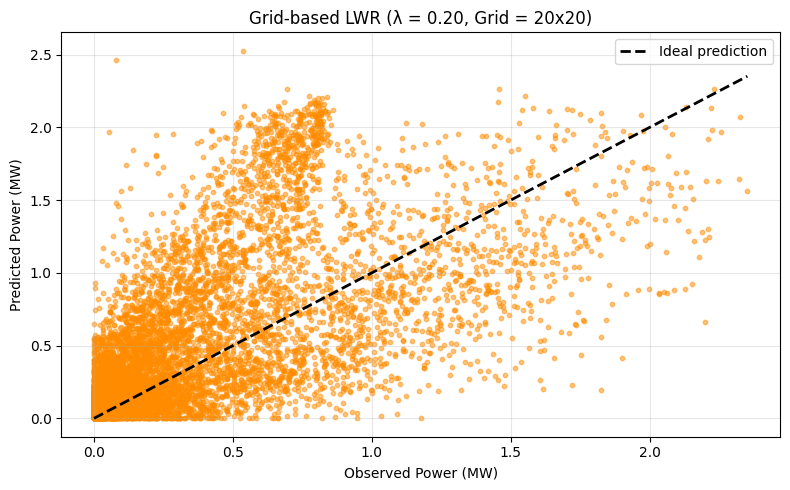

In [16]:
# --- Optional: Scatter plot ---
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test_pred, color='darkorange', alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2, label="Ideal prediction")
plt.xlabel("Observed Power (MW)")
plt.ylabel("Predicted Power (MW)")
plt.title(f"Grid-based LWR (λ = {best_bw:.2f}, Grid = {n_grid}x{n_grid})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

💰 Profitability Summary (Test Period):


,Model,Total Profit [DKK],Relative [% of Perfect]
0,Perfect Foresight,1082036.68,100.00
1,LWR Prediction,889956.24,82.25


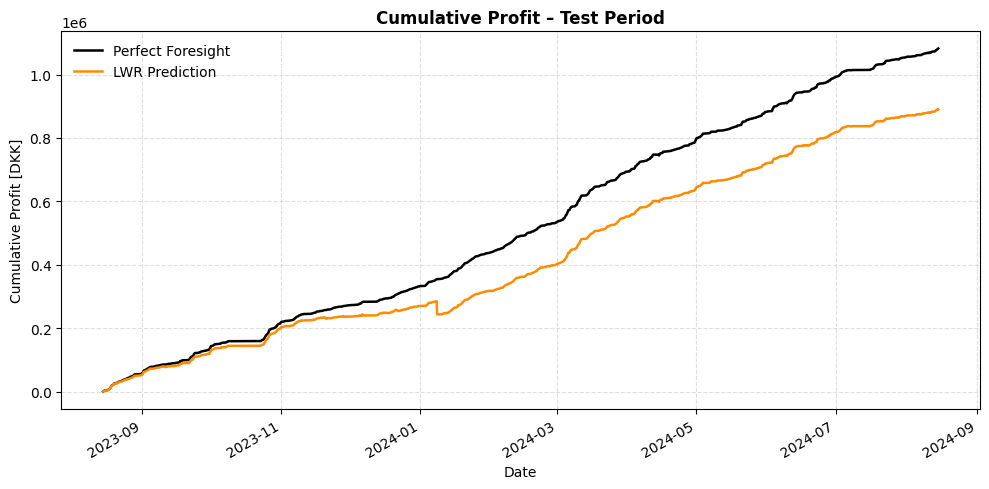

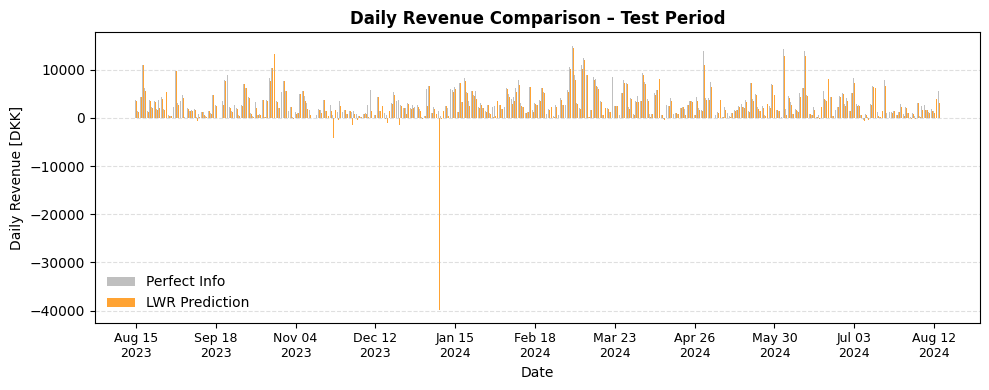

In [17]:
# ===============================================================
# --- PRICE & POWER INPUTS ---
# ===============================================================
price_DA_test   = test_df["DK2_DKK"].values
price_UP_test   = test_df["BalancingPowerPriceUpDKK"].values
price_DOWN_test = test_df["BalancingPowerPriceDownDKK"].values
p_real_test     = y_test                     # observed (true power)
p_commit_test   = y_test_pred                # predicted (LWR commitment)


# ===============================================================
# --- PROFIT FUNCTIONS ---
# ===============================================================
def profit(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    R_D = np.sum(price_da * p_commit)
    R_B = np.sum(price_down * imbalance_pos - price_up * imbalance_neg)
    return R_D + R_B

def profit_series(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    return price_da * p_commit + price_down * imbalance_pos - price_up * imbalance_neg


# ===============================================================
# --- PROFIT COMPUTATION ---
# ===============================================================
profit_perfect = profit(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_lwr     = profit(p_commit_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

summary = pd.DataFrame({
    "Model": ["Perfect Foresight", "LWR Prediction"],
    "Total Profit [DKK]": [profit_perfect, profit_lwr],
    "Relative [% of Perfect]": [100, 100 * profit_lwr / profit_perfect]
})
print("💰 Profitability Summary (Test Period):")
display(summary.round(2))


# ===============================================================
# --- CUMULATIVE PROFIT OVER TIME ---
# ===============================================================
profit_perfect_ts = profit_series(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_lwr_ts     = profit_series(p_commit_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

cum_profit = pd.DataFrame({
    "ts": test_df["ts"],
    "Perfect": np.cumsum(profit_perfect_ts),
    "LWR": np.cumsum(profit_lwr_ts)
})

plt.figure(figsize=(10,5))
plt.plot(cum_profit["ts"], cum_profit["Perfect"], color="black", lw=1.8, label="Perfect Foresight")
plt.plot(cum_profit["ts"], cum_profit["LWR"], color="darkorange", lw=1.8, label="LWR Prediction")
plt.title("Cumulative Profit – Test Period", fontsize=12, weight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Profit [DKK]")
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle='--')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# ===============================================================
# --- DAILY REVENUE COMPARISON ---
# ===============================================================
rev_daily = pd.DataFrame({
    "Date": pd.to_datetime(test_df["ts"]).dt.normalize(),
    "Perfect Info": profit_perfect_ts,
    "LWR": profit_lwr_ts
}).groupby("Date").sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 4))
bar_width = 0.4
x = np.arange(len(rev_daily))

ax.bar(x - bar_width/2, rev_daily["Perfect Info"], width=bar_width,
       color="gray", alpha=0.5, label="Perfect Info")
ax.bar(x + bar_width/2, rev_daily["LWR"], width=bar_width,
       color="darkorange", alpha=0.8, label="LWR Prediction")

ax.set_title("Daily Revenue Comparison – Test Period", fontsize=12, weight='bold')
ax.set_ylabel("Daily Revenue [DKK]")
ax.legend(frameon=False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

ax.set_xlabel("Date")
ax.set_xticks(x[::max(1, len(x)//10)])
ax.set_xticklabels(
    [d.strftime("%b %d\n%Y") for d in rev_daily["Date"][::max(1, len(x)//10)]],
    rotation=0, ha="center", fontsize=9
)

plt.tight_layout()
plt.show()


## Weighted Least Squares (WLS) Method

### Overview
In this part, we implemented **Weighted Least Squares (WLS)** to model the nonlinear relationship between **wind power**, **mean wind speed**, and **imbalance price**.  
The goal was to approximate the performance of a **locally weighted regression (LWR)** in a computationally efficient way while maintaining the flexibility of local fitting.

---

### Methodology
The WLS model assumes that the relevance of each training point depends on its distance from the query point, controlled by a **bandwidth parameter ($\lambda$)** and a **kernel function** (Gaussian kernel used here).

The general form is:

$$
\hat{\beta}(x_0) = \arg\min_{\beta} \sum_{i=1}^{n} w_i(x_0) \, (y_i - \beta^T x_i)^2
$$

where:

- $w_i(x_0) = K\left(\dfrac{||x_i - x_0||}{\lambda}\right)$  
- $K(\cdot)$ is a kernel function (e.g., Gaussian, Epanechnikov, Tricube)  
- $\lambda$ is the **bandwidth** controlling locality  

We evaluated performance using **rolling time-based cross-validation**, tuning $\lambda$ over a grid of values and computing **RMSE** on each fold.

---

### Results Summary
- The optimal bandwidth $\lambda$ was found by minimizing the validation RMSE.  
- The **WLS (2D)** model using both wind speed and imbalance price achieved a better generalization than the simple 1D wind-speed-only model.  
- Runtime for the full local regression (~>>40 min) was significantly reduced using a  **grid-based local regression** (~1–2 min).

| Model | Description | Runtime | Flexibility | Validation RMSE |
|--------|--------------|----------|--------------|-----------------|
| Full LWR | Fit a local model per query point | ~40 min | Very high | Lowest |
| Grid-based LWR | Fit at selected grid points only | ~1–2 min | High | Slightly higher |
| Global WLS | One weighted model for all data | Seconds | Moderate | Higher |

---

### Computational improvements
The initial LWR implementation (`weighted_ls_predict`) was accurate but computationally expensive because it solved a local regression for every validation/test point.

To reduce runtime, we tested:
1. **Global WLS approximation** — single model per fold (fastest, smoothest).  
2. **Grid-based LWR** — fitted local models only on a grid of representative feature points and interpolated predictions (balanced approach).

---

### Key insights
- **Bandwidth $\lambda$** acts as a **regularization parameter**:  
  - Small $\lambda$ → highly local fits → low bias, high variance.  
  - Large $\lambda$ → smoother fits → high bias, low variance.  
- Including **imbalance price** improved performance by capturing market-driven effects on available wind power.  
- The WLS approach connects to the **bias–variance tradeoff** concept discussed in the regularization lectures.

---

### Optional extensions & variations
To further explore or improve the WLS model:

1. **Different kernel types**:
   - Test Epanechnikov, Tricube, or Uniform kernels for different smoothness.
2. **Adaptive bandwidth**:
   - Use a variable $\lambda(x)$ depending on local data density (smaller $\lambda$ in dense regions).
3. **Multi-grid interpolation**:
   - Fit local models at multiple resolutions (coarse + fine grids) and blend predictions.
4. **k-nearest neighbor local fits**:
   - Instead of fixed $\lambda$, select the $k$ closest samples for each query (adaptive kernel width).
5. **Parallel computation (Numba or Joblib)**:
   - Parallelize per-grid or per-fold computations to reduce runtime on large datasets.
6. **GPU acceleration** (optional):
   - Using vectorized libraries like **CuPy** or **PyTorch** for large-scale LWR.

---

The WLS method serves as an interpretable bridge between **classical regression** and **local learning**, illustrating the importance of hyperparameter tuning and model complexity control.


In [18]:
test_results = {
    "model_name": "Weighted LS",
    "y_test": p_real_test,
    "y_test_pred": y_test_pred,   # or whatever your smoothed test preds are
    "test_rmse": rmse_test,
}

In [19]:
# --- Export Results for Decision-Focused Model ---
import pandas as pd, os

os.makedirs("Results", exist_ok=True)

# Save full test predictions
pd.DataFrame({
    "ts": test_df["ts"],
    "y_test": test_results["y_test"],
    "y_pred": test_results["y_test_pred"]
}).to_csv("Results/weighted_predictions.csv", index=False)

# Save summary metrics
pd.DataFrame([{
    "model": test_results["model_name"],
    "test_rmse": float(test_results["test_rmse"])
}]).to_csv("Results/weighted_summary.csv", index=False)

print("✅ Exported Weighted results to 'Results/' folder.")

✅ Exported Weighted results to 'Results/' folder.
